## 2. Data Sampling

- 라벨 불균형을 극복할 수 있는 데이터 기반의 샘플링 기법을 실습
- 데이터셋: OPENML의 소득 데이터셋

### 2.1 Load Dataset

- 데이터셋을 확인하고 연속형 feature와 이산형 feature의 분포를 파악합니다.

In [ ]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from pathlib import Path

path_lecture = Path("data")
adult_data = fetch_openml(name="adult", version=2, as_frame=True)
raw_df = adult_data.frame
raw_df.to_csv(path_lecture / "adult_income.csv", index=False)

display(raw_df.head())
print(f"Data Shape: {raw_df.shape}", end="\n\n")


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


Data Shape: (48842, 15)



### 2.2 Basic EDA

- 연속형 feature와 이산형 feature의 분포를 파악합니다.

#### Adult Census Income 데이터셋 칼럼 설명

| 칼럼명 | 설명 | 데이터 유형 |
|--------|------|------------|
| **age** | 나이 | 연속형 (Continuous) |
| **workclass** | 고용 유형 (민간, 정부, 자영업 등) | 이산형 (Categorical) |
| **fnlwgt** | 샘플 가중치 (인구 통계학적 확장을 위한 값) | 연속형 (Continuous) |
| **education** | 교육 수준 (예: 고등학교 졸업, 학사 등) | 이산형 (Categorical) |
| **education-num** | 교육 수준을 숫자로 변환한 값 | 이산형 (Ordinal) |
| **marital-status** | 결혼 상태 (기혼, 미혼, 이혼 등) | 이산형 (Categorical) |
| **occupation** | 직업 유형 (관리자, 기술자, 서비스업 등) | 이산형 (Categorical) |
| **relationship** | 가구 내 관계 (배우자, 자녀, 부모 등) | 이산형 (Categorical) |
| **race** | 인종 | 이산형 (Categorical) |
| **sex** | 성별 | 이산형 (Categorical) |
| **capital-gain** | 자본 이득 (투자 수익) | 연속형 (Continuous) |
| **capital-loss** | 자본 손실 (투자 손실) | 연속형 (Continuous) |
| **hours-per-week** | 주당 근무 시간 | 연속형 (Continuous) |
| **native-country** | 출생 국가 | 이산형 (Categorical) |
| **class** | 소득 수준 (<=50K 또는 >50K) | 이산형 (Categorical) |


In [3]:
print(raw_df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'class'],
      dtype='object')


In [4]:
# unique() 이후의 데이터 길이가 50을 넘어가면 연속형이라 판단해도 좋을 것 같습니다.
# threshold 50을 기점으로 분류한 것이 문제 없이 통하는 것으로 확인이 됩니다.
threshold = 50
target = "class"
data = {
    "discrete" : [],
    "continuous" : []
}

df = raw_df.dropna(how="any")

for col in df.columns:
    if len(df[col].unique()) > threshold:
        data['continuous'].append(col)
    else:
        data['discrete'].append(col)

display(df[data['discrete']].head(10))
display(df[data['continuous']].head(10))

,workclass,education,education-num,marital-status,occupation,relationship,race,sex,native-country,class
0,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,<=50K
1,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,<=50K
2,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K
3,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,>50K
5,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,United-States,<=50K
7,Self-emp-not-inc,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,>50K
8,Private,Some-college,10,Never-married,Other-service,Unmarried,White,Female,United-States,<=50K
9,Private,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
10,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
11,Federal-gov,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,<=50K


,age,fnlwgt,capital-gain,capital-loss,hours-per-week
0,25,226802,0,0,40
1,38,89814,0,0,50
2,28,336951,0,0,40
3,44,160323,7688,0,40
5,34,198693,0,0,30
7,63,104626,3103,0,32
8,24,369667,0,0,40
9,55,104996,0,0,10
10,65,184454,6418,0,40
11,36,212465,0,0,40


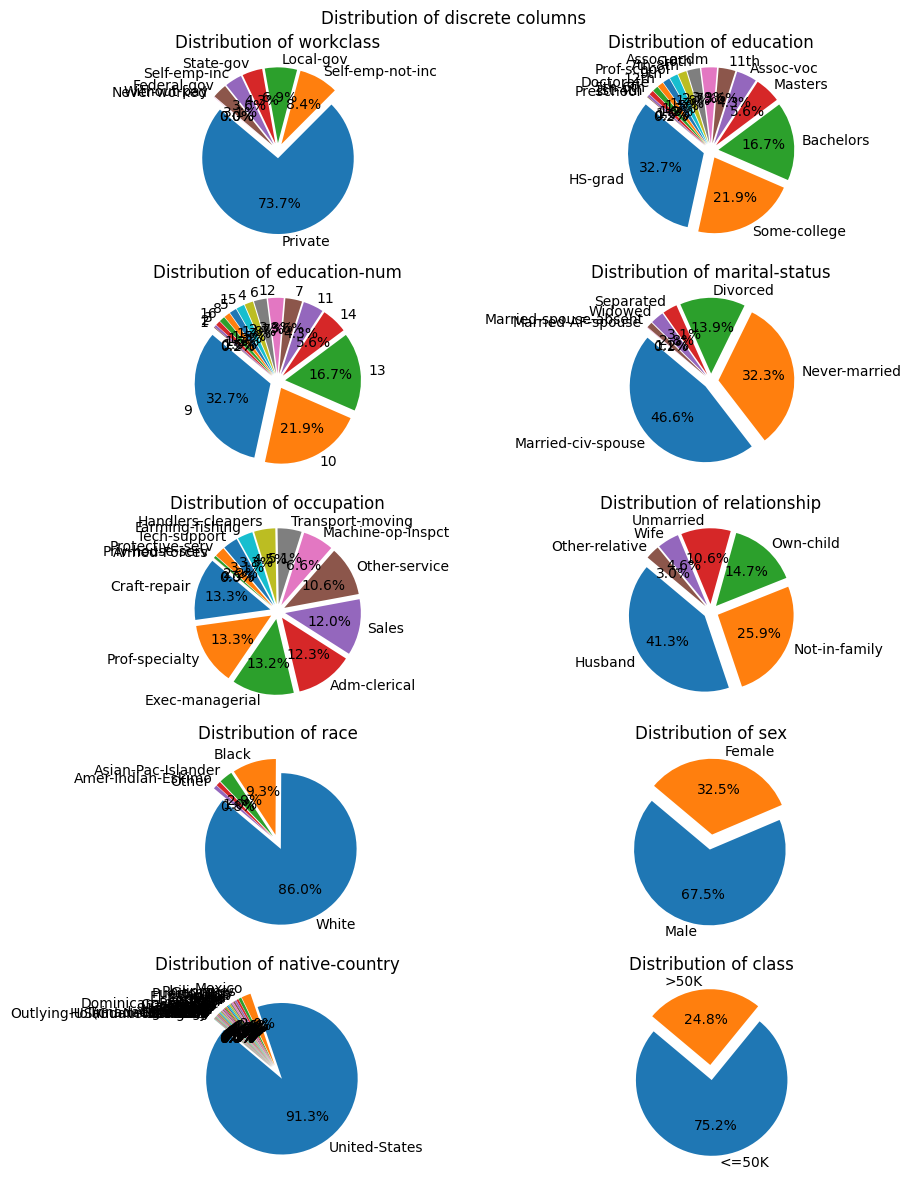

In [5]:
plt.figure(figsize=(10,12))
columns = data['discrete']
for i, column in enumerate(columns):
    values = df[columns][column].value_counts().values.tolist()
    labels = df[columns][column].value_counts().index.tolist()
    explode = [0.1 for _ in range(len(values))]
    plt.subplot(5,2,i+1)
    plt.pie(values, labels=labels, explode = explode, autopct='%1.1f%%', startangle=140) 
    plt.title(f"Distribution of {column}")

plt.suptitle("Distribution of discrete columns")
plt.tight_layout()

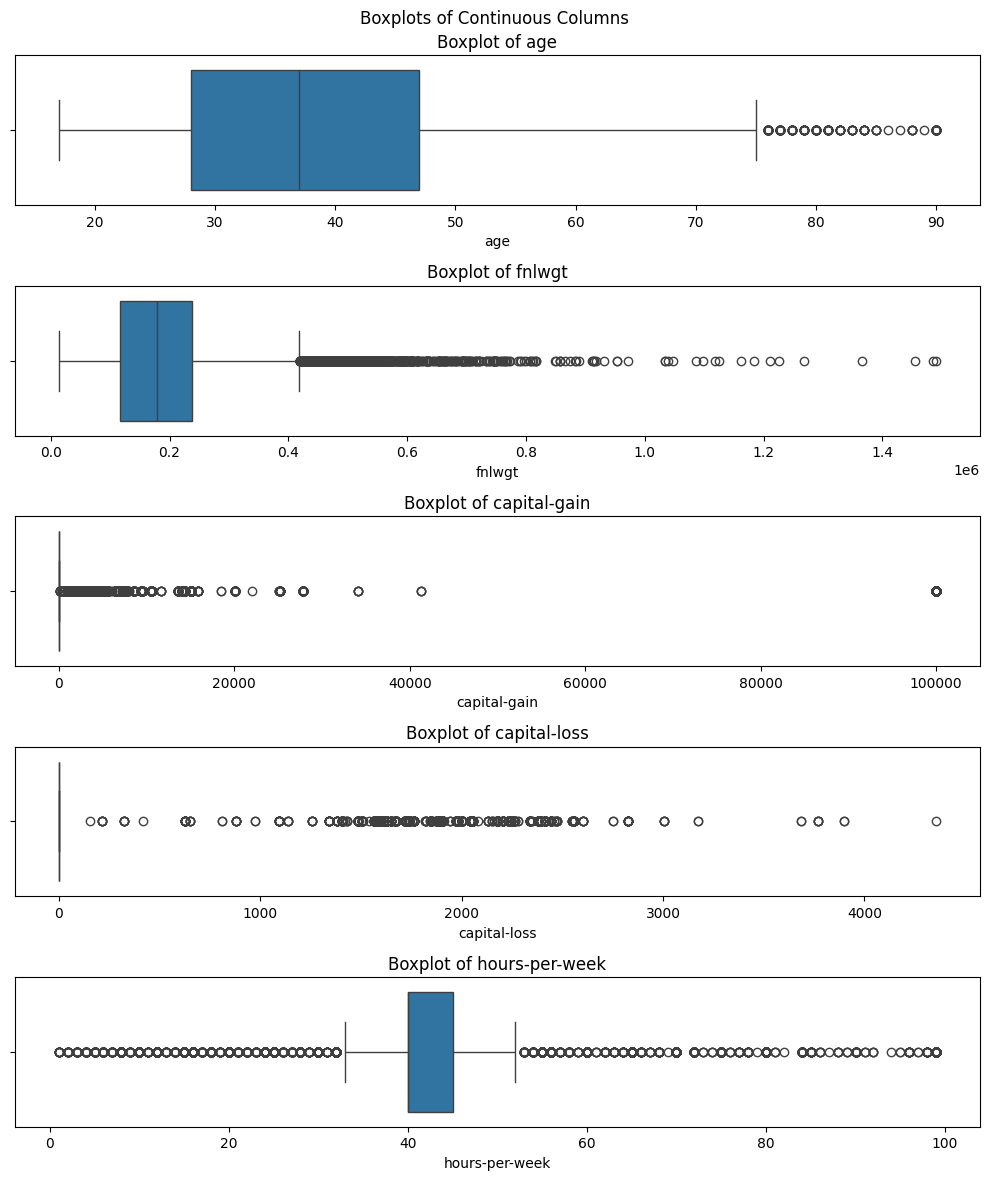

In [6]:
columns = data['continuous']

plt.figure(figsize=(10, 12))
for i, column in enumerate(columns):
    plt.subplot(5, 1, i + 1)  # 5개의 플롯을 세로로 정렬
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {column}")

plt.suptitle("Boxplots of Continuous Columns")
plt.tight_layout()
plt.show()

### 2.3 Oversampling Methods

- simple oversampling

- cluster + stratify oversampling

- SMOTE

- ADASYN

#### 2.3.1 Simple Oversampling

In [7]:
import random
difference = len(df[df[target] == "<=50K"]) - len(df[df[target] == ">50K"])
print(difference, len(df[df[target] == ">50K"]), len(df[df[target] == "<=50K"]))
oversampling_index = list(df[df[target] == ">50K"].index)
difference_df = df.loc[random.choices(oversampling_index, k=difference)]
df = pd.concat([df,difference_df], axis=0)
df.head()

22806 11208 34014


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


#### 2.3.2 stratify + cluster Sampling

In [8]:
# 나이라는 연속형 변수를 이산형 변수로 전환합니다.
# 이후에 cluster를 key로 하여 stratify 하게 sampling을 합니다.

df = copy.deepcopy(raw_df)
difference = len(df[df[target] == "<=50K"]) - len(df[df[target] == ">50K"])

df['cluster'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70], labels=['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'])
print("Sampling 전 비율", df['cluster'].value_counts(normalize=True), sep="\n\n", end="\n\n")
stratify_proportion = df['cluster'].value_counts(normalize=True).to_dict()
stratify_proportion = {k:{"proportion":v} for k,v in stratify_proportion.items()}

result = []
for key, value in stratify_proportion.items():
    stratify_proportion[key]["nums"] = int(difference * stratify_proportion[key]['proportion'])
    index = list(df[(df['cluster'] == key) & (df['class'] == ">50K")].index)
    oversampling_index = random.choices(index, k = stratify_proportion[key]["nums"])
    sampled_df = df.iloc[oversampling_index]
    result.append(sampled_df)
result.append(df)

df = pd.concat(result, axis=0)
print("Sampling 후 비율", df['cluster'].value_counts(normalize=True), sep="\n\n", end="\n\n")
print(df['class'].value_counts())
display(df.head(3))

Sampling 전 비율

cluster
cluster_2    0.289464
cluster_1    0.274402
cluster_3    0.234561
cluster_4    0.139839
cluster_5    0.061735
Name: proportion, dtype: float64

Sampling 후 비율

cluster
cluster_2    0.289471
cluster_1    0.274403
cluster_3    0.234556
cluster_4    0.139837
cluster_5    0.061733
Name: proportion, dtype: float64

class
<=50K    37155
>50K     37153
Name: count, dtype: int64


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,cluster
9842,40,Local-gov,166822,Masters,14,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,36,United-States,>50K,cluster_2
45546,36,Private,148581,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,55,United-States,>50K,cluster_2
16157,38,Private,108140,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,>50K,cluster_2


#### 2.3.3 SMOTE

In [9]:
from imblearn.over_sampling import SMOTE, ADASYN

df = copy.deepcopy(raw_df)
X = df[data['continuous']]
y = df['class']
random_state = 42
original_df = pd.concat([X,y], axis=1)
print(original_df.shape, end="\n\n")
print(original_df['class'].value_counts())

smote = SMOTE(random_state=random_state)
X_resampled, y_resampled = smote.fit_resample(X, y)
oversampled_df = pd.concat([X_resampled, y_resampled], axis=1)
print(oversampled_df.shape, end="\n\n")
print(oversampled_df['class'].value_counts())

(48842, 6)

class
<=50K    37155
>50K     11687
Name: count, dtype: int64
(74310, 6)

class
<=50K    37155
>50K     37155
Name: count, dtype: int64


#### 2.3.4 AdaSYN

In [10]:
df = copy.deepcopy(raw_df)
X = df[data['continuous']]
y = df['class']
original_df = pd.concat([X,y], axis=1)
print(original_df.shape, end="\n\n")
print(original_df['class'].value_counts())

smote = ADASYN(random_state=random_state)
X_resampled, y_resampled = smote.fit_resample(X, y)
oversampled_df = pd.concat([X_resampled, y_resampled], axis=1)
print(oversampled_df.shape, end="\n\n")
print(oversampled_df['class'].value_counts())

(48842, 6)

class
<=50K    37155
>50K     11687
Name: count, dtype: int64
(74904, 6)

class
>50K     37749
<=50K    37155
Name: count, dtype: int64
